# Ocean Health Dataset EDA

In [20]:
%run -i imports.py
v = sys.version_info
print(f"Python version {v.major}.{v.minor}.{v.micro}")
print(f"Run at {dt.datetime.now()}")

Python version 3.12.12
Run at 2026-01-28 16:03:10.960595


In [ ]:
df = pd.read_csv('../data/ocean_health_index.csv')
print(df.shape)
print(df.columns)

(194, 15)
Index(['REF_AREA', 'REF_AREA_LABEL', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
      dtype='str')
  REF_AREA        REF_AREA_LABEL   2012   2013   2014   2015   2016   2017  \
0      ABW                 Aruba  70.79  70.10  70.09  70.52  71.28  72.14   
1      AGO                Angola  63.33  64.57  64.57  67.00  67.66  66.70   
2      AIA              Anguilla  72.17  70.60  70.82  70.86  70.74  70.21   
3      ALB               Albania  62.95  63.27  63.86  66.55  66.16  66.70   
4      ANT  Netherlands Antilles  74.66  74.98  74.97  74.92  77.45  77.45   

    2018   2019   2020   2021   2022   2023   2024  
0  77.65  80.87  79.94  79.39  76.43  64.90  67.50  
1  65.71  61.90  59.76  59.23  59.41  57.91  57.89  
2  70.36  70.30  70.36  70.35  70.44  70.63  70.87  
3  67.38  67.52  71.79  71.70  71.19  65.38  69.68  
4  77.44  77.44  76.61  76.51  76.33  76.35  76.34  


In [ ]:
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REF_AREA        194 non-null    str    
 1   REF_AREA_LABEL  194 non-null    str    
 2   2012            194 non-null    float64
 3   2013            194 non-null    float64
 4   2014            194 non-null    float64
 5   2015            194 non-null    float64
 6   2016            194 non-null    float64
 7   2017            194 non-null    float64
 8   2018            194 non-null    float64
 9   2019            194 non-null    float64
 10  2020            194 non-null    float64
 11  2021            194 non-null    float64
 12  2022            194 non-null    float64
 13  2023            194 non-null    float64
 14  2024            194 non-null    float64
dtypes: float64(13), str(2)
memory usage: 22.9 KB
None


In [25]:
print(df.describe())

             2012        2013        2014        2015        2016        2017  \
count  194.000000  194.000000  194.000000  194.000000  194.000000  194.000000   
mean    69.138144   69.758299   70.184742   70.746031   70.863247   70.788247   
std      5.969848    5.936358    6.010257    6.019021    6.025836    6.173841   
min     48.670000   48.780000   50.870000   51.230000   50.930000   51.110000   
25%     65.105000   65.440000   66.080000   66.992500   67.337500   67.337500   
50%     69.665000   70.135000   70.605000   71.120000   71.185000   71.200000   
75%     72.875000   73.425000   74.202500   74.872500   74.777500   74.825000   
max     82.740000   82.130000   83.060000   83.490000   83.440000   84.350000   

             2018        2019        2020        2021        2022        2023  \
count  194.000000  194.000000  194.000000  194.000000  194.000000  194.000000   
mean    70.984536   71.217320   71.448144   71.356649   71.382062   66.585361   
std      6.195274    6.1754

In [ ]:
df_long = df.melt(id_vars=['REF_AREA', 'REF_AREA_LABEL'], var_name='Year')

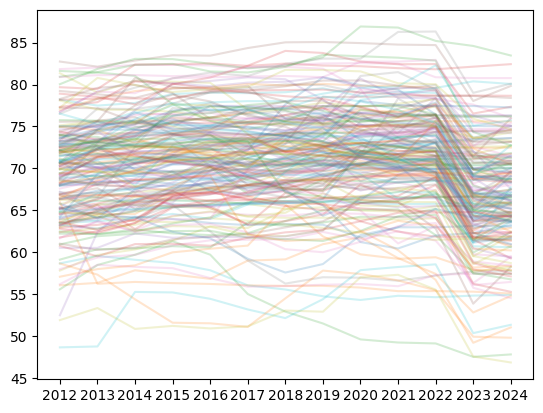

In [32]:
for country_code, df_country in df.groupby('REF_AREA'):
    plt.plot(df_country.columns[2:], df_country.iloc[0, 2:], label=df_country['REF_AREA_LABEL'].values[0], alpha=0.2)